# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters

In [3]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [5]:
params = vaep.nb.get_params(args, globals=globals())
params

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


{'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'folder_experiment': 'runs/alzheimer_study',
 'model_key': 'RF',
 'target': 'AD',
 'sample_id_col': 'Sample ID',
 'cutoff_target': 0.5,
 'file_format': 'csv',
 'out_folder': 'diff_analysis',
 'fn_qc_samples': '',
 'baseline': 'PI',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

In [7]:
files_out = dict()

## Load target

In [8]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### Measured data

In [9]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_105  Q9UKM7                            15.299
Sample_062  E9PKE3;P11142                     16.011
Sample_166  O94919                            18.845
Sample_095  P62258                            16.735
Sample_177  P41217;P41217-2;P41217-3;U3KQG5   15.746
Name: intensity, dtype: float64

Get overlap between independent features and target

### Load ALD data or create

In [10]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [11]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load semi-supervised model imputations

In [12]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups        
Sample_050  O75636;O75636-2          15.230
Sample_150  J3KSJ8;Q9UD71;Q9UD71-2   11.692
Sample_144  O94898                   14.710
Name: intensity, dtype: float64

In [13]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.864
            A0A075B6Q5                 12.824
            A0A075B6R2                 14.377
            A0A075B6S5                 12.867
            A0A087WSY4                 13.261
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.135
            Q9UI40;Q9UI40-2            12.264
            Q9UIW2                     12.081
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.723
            Q9UP79                     11.536
Name: intensity, Length: 46401, dtype: float64

## Model predictions
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
3. newly available feat only: the subset of features available from the
self supervised deep learning model which were newly retained using the
new approach

In [14]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.284,15.050,16.842,19.863,15.625,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.368,19.067,...,15.528,15.576,14.166,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.749,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.422,17.705,17.039,15.888,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.709,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,13.932,15.345,17.084,18.708,14.249,19.433,11.927,11.264
Sample_207,15.739,16.877,15.469,16.898,15.177,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [15]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.864,...,16.012,15.178,13.415,15.050,16.842,19.863,13.477,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.554,19.067,16.188,...,15.528,15.576,13.143,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.862,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.685,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.334,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.652,15.345,17.084,18.708,14.249,19.433,13.733,12.037
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [16]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification


In [17]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Best number of parameters by CV

In [18]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 315.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.26it/s]

100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.94it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.61it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.59it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.80it/s]

100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.11it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.38it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.31it/s]

100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.63it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.53it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.77it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.76it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.82it/s]

100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.53it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.40it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.78it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.50it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.36it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.64it/s]

100%|██████████| 8/8 [00:02<00:00,  2.10it/s]

100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.67it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.18it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.86it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.82it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.52it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.29it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.43it/s]

100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.74it/s]

 30%|███       | 3/10 [00:00<00:01,  4.15it/s]

 40%|████      | 4/10 [00:00<00:01,  3.79it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.76it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.72it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.74it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.83it/s]

100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.10it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.73it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.96it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.67it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.37it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.86it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.45it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.44it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.37it/s]

100%|██████████| 11/11 [00:03<00:00,  2.33it/s]

100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.14it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.06it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.31it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.13it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.94it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.80it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.87it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.03it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.06it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.22it/s]

100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

100%|██████████| 12/12 [00:05<00:00,  2.21it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.30it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.97it/s]

 31%|███       | 4/13 [00:01<00:03,  2.84it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.93it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.94it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.89it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.86it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.75it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.80it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.78it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.74it/s]

100%|██████████| 13/13 [00:04<00:00,  2.18it/s]

100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.17it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.27it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.51it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.28it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.97it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.74it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.91it/s]

 64%|██████▍   | 9/14 [00:02<00:02,  2.37it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.30it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.52it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.78it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.91it/s]

100%|██████████| 14/14 [00:04<00:00,  3.22it/s]

100%|██████████| 14/14 [00:04<00:00,  3.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.02it/s]

 20%|██        | 3/15 [00:00<00:03,  3.96it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.85it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.54it/s]

 40%|████      | 6/15 [00:02<00:03,  2.48it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.44it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.58it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.73it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.84it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.89it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.86it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.87it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.94it/s]

100%|██████████| 15/15 [00:05<00:00,  2.84it/s]

100%|██████████| 15/15 [00:05<00:00,  2.85it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.060 0.022          0.756 0.355       0.114   
2             0.004 0.002      0.065 0.024          0.697 0.118       0.638   
3             0.005 0.003      0.060 0.024          0.706 0.117       0.624   
4             0.005 0.003      0.059 0.019          0.694 0.115       0.609   
5             0.004 0.000      0.050 0.009          0.727 0.108       0.647   
6             0.004 0.002      0.049 0.009          0.715 0.099       0.669   
7             0.004 0.002      0.052 0.021          0.795 0.092       0.798   
8             0.006 0.005      0.074 0.029          0.791 0.092       0.797   
9             0.005 0.004      0.054 0.014          0.797 0.091       0.804   
10            0.007 0.007      0.069 0.028          0.810 0.079       0.831   
11            0.007 0.005      0.070 0.027          0.813 0.076       0.823   
12            0.010 0.011      0.088 0.039          0.822 0.085       0.830   
13            0.005 0.004      0.061 0.021          0.821 0.085       0.825   
14            0.004 0.002      0.046 0.015          0.818 0.090       0.815   
15            0.004 0.000      0.047 0.001          0.814 0.089       0.813   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.192 0.126                  0.550 0.040        0.849   
2          0.124   0.657 0.090                  0.712 0.073        0.788   
3          0.135   0.653 0.099                  0.712 0.078        0.791   
4          0.134   0.639 0.096                  0.701 0.074        0.786   
5          0.106   0.677 0.078                  0.730 0.061        0.823   
6          0.112   0.685 0.082                  0.734 0.066        0.822   
7          0.107   0.791 0.074                  0.821 0.062        0.899   
8          0.109   0.788 0.074                  0.819 0.063        0.897   
9          0.102   0.795 0.073                  0.825 0.062        0.896   
10         0.107   0.816 0.068                  0.843 0.058        0.904   
11         0.099   0.813 0.065                  0.841 0.055        0.906   
12         0.094   0.823 0.071                  0.848 0.061        0.909   
13         0.097   0.820 0.074                  0.846 0.063        0.908   
14         0.098   0.813 0.074                  0.840 0.064        0.905   
15         0.098   0.809 0.071                  0.837 0.061        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.088        210.000 0.000  
2          0.073                  0.731 0.092        210.000 0.000  
3          0.076                  0.729 0.095        210.000 0.000  
4          0.077                  0.718 0.097        210.000 0.000  
5          0.064                  0.784 0.088        210.000 0.000  
6          0.066                  0.779 0.092        210.000 0.000  
7          0.051                  0.878 0.060        210.000 0.000  
8          0.051                  0.876 0.060        210.000 0.000  
9          0.051                  0.876 0.058        210.000 0.000  
10         0.051                  0.890 0.056        210.000 0.000  
11         0.051                  0.895 0.056        210.000 0.000  
12         0.052                  0.900 0.053        210.000 0.000  
13         0.052                  0.899 0.053        210.000 0.000  
14         0.054                  0.896 0.055        210.000 0.000  
15         0.053                  0.894 0.056 

In [19]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 67.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.99it/s]

100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.89it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.97it/s]

100%|██████████| 4/4 [00:01<00:00,  1.89it/s]

100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.44it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.52it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.47it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.92it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.61it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.38it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.51it/s]

100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.62it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.85it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.31it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.26it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.08it/s]

100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.38it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.45it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.16it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.98it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.03it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.30it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.07it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.88it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.81it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.72it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.94it/s]

100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.60it/s]

 30%|███       | 3/10 [00:01<00:02,  2.68it/s]

 40%|████      | 4/10 [00:01<00:02,  2.10it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.85it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.93it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.00it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.05it/s]

100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.04it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.37it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.82it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.86it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.74it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.71it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.70it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.68it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.67it/s]

100%|██████████| 11/11 [00:03<00:00,  2.63it/s]

100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.40it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.53it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.19it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.98it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.88it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.73it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.40it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.18it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.09it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.06it/s]

100%|██████████| 12/12 [00:04<00:00,  2.21it/s]

100%|██████████| 12/12 [00:04<00:00,  2.50it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.88it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.57it/s]

 31%|███       | 4/13 [00:01<00:03,  2.64it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.27it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.07it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.11it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.18it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.25it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.27it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.37it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.38it/s]

100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.31it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.31it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.95it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.74it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.63it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.58it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.45it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.40it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.42it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.53it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.13it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.02it/s]

100%|██████████| 14/14 [00:05<00:00,  2.05it/s]

100%|██████████| 14/14 [00:05<00:00,  2.41it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.93it/s]

 20%|██        | 3/15 [00:00<00:03,  3.43it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.10it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.96it/s]

 40%|████      | 6/15 [00:01<00:03,  2.85it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.74it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.74it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.75it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.73it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.35it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.14it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.91it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  1.84it/s]

100%|██████████| 15/15 [00:06<00:00,  1.79it/s]

100%|██████████| 15/15 [00:06<00:00,  2.34it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.072 0.031          0.000 0.000       0.000   
2             0.006 0.005      0.074 0.024          0.670 0.114       0.434   
3             0.005 0.004      0.060 0.021          0.782 0.088       0.679   
4             0.005 0.004      0.062 0.024          0.746 0.100       0.683   
5             0.006 0.005      0.068 0.024          0.741 0.101       0.685   
6             0.005 0.003      0.052 0.012          0.753 0.100       0.701   
7             0.004 0.001      0.050 0.011          0.756 0.096       0.720   
8             0.006 0.005      0.069 0.033          0.750 0.097       0.722   
9             0.006 0.005      0.066 0.023          0.795 0.088       0.748   
10            0.005 0.003      0.057 0.018          0.792 0.095       0.756   
11            0.007 0.006      0.078 0.032          0.785 0.092       0.761   
12            0.005 0.004      0.065 0.026          0.849 0.083       0.807   
13            0.006 0.005      0.071 0.025          0.848 0.075       0.810   
14            0.007 0.006      0.071 0.029          0.850 0.075       0.822   
15            0.007 0.006      0.065 0.021          0.847 0.080       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.008        0.851   
2          0.121   0.516 0.105                  0.637 0.059        0.686   
3          0.116   0.721 0.088                  0.769 0.065        0.870   
4          0.126   0.705 0.091                  0.754 0.069        0.871   
5          0.127   0.704 0.092                  0.753 0.070        0.867   
6          0.111   0.720 0.082                  0.763 0.065        0.873   
7          0.112   0.731 0.078                  0.772 0.063        0.871   
8          0.111   0.730 0.078                  0.770 0.063        0.870   
9          0.121   0.764 0.083                  0.801 0.066        0.904   
10         0.115   0.767 0.083                  0.803 0.068        0.906   
11         0.108   0.767 0.076                  0.802 0.063        0.906   
12         0.093   0.824 0.072                  0.850 0.060        0.929   
13         0.088   0.825 0.062                  0.851 0.052        0.931   
14         0.089   0.832 0.063                  0.857 0.053        0.934   
15         0.099   0.831 0.070                  0.856 0.059        0.935   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.821 0.086        210.000 0.000  
2          0.084                  0.655 0.085        210.000 0.000  
3          0.054                  0.844 0.073        210.000 0.000  
4          0.051                  0.842 0.063        210.000 0.000  
5          0.052                  0.837 0.065        210.000 0.000  
6          0.049                  0.841 0.063        210.000 0.000  
7          0.050                  0.834 0.070        210.000 0.000  
8          0.050                  0.832 0.070        210.000 0.000  
9          0.042                  0.883 0.056        210.000 0.000  
10         0.045                  0.883 0.058        210.000 0.000  
11         0.045                  0.884 0.057        210.000 0.000  
12         0.038                  0.918 0.042        210.000 0.000  
13         0.038                  0.918 0.044        210.000 0.000  
14         0.037                  0.920 0.043        210.000 0.000  
15         0.036                  0.923 0.040 

In [20]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 996.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.42it/s]

100%|██████████| 3/3 [00:00<00:00, 20.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.04it/s]

100%|██████████| 4/4 [00:00<00:00, 13.03it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.66it/s]

100%|██████████| 5/5 [00:00<00:00, 14.20it/s]

100%|██████████| 5/5 [00:00<00:00, 14.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.39it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.46it/s]

100%|██████████| 6/6 [00:00<00:00, 13.50it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 17.66it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  9.88it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  8.86it/s]

100%|██████████| 7/7 [00:00<00:00,  8.68it/s]

100%|██████████| 7/7 [00:00<00:00,  9.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 17.82it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.76it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.33it/s]

100%|██████████| 8/8 [00:00<00:00, 11.69it/s]

100%|██████████| 8/8 [00:00<00:00, 12.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.97it/s]

 44%|████▍     | 4/9 [00:00<00:00, 15.45it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.67it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.54it/s]

100%|██████████| 9/9 [00:00<00:00, 13.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.14it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.72it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.15it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.15it/s]

100%|██████████| 10/10 [00:00<00:00, 12.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.29it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.20it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.77it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.12it/s]

100%|██████████| 11/11 [00:00<00:00, 11.09it/s]

100%|██████████| 11/11 [00:00<00:00, 11.64it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.08it/s]

 42%|████▏     | 5/12 [00:00<00:00, 12.98it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.53it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.07it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.16it/s]

100%|██████████| 12/12 [00:01<00:00, 11.47it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.17it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.00it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.05it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.96it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.56it/s]

100%|██████████| 13/13 [00:00<00:00, 13.10it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 13.20it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.01it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.63it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.53it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  9.43it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.72it/s]

100%|██████████| 14/14 [00:01<00:00, 10.25it/s]

100%|██████████| 14/14 [00:01<00:00, 10.15it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.20it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.84it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.81it/s]

 60%|██████    | 9/15 [00:00<00:00, 14.91it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.20it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 11.66it/s]

100%|██████████| 15/15 [00:01<00:00, 11.25it/s]

100%|██████████| 15/15 [00:01<00:00, 12.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.057 0.022          0.000 0.000       0.000   
2             0.006 0.006      0.084 0.035          0.584 0.109       0.358   
3             0.005 0.004      0.062 0.021          0.599 0.127       0.352   
4             0.005 0.004      0.065 0.023          0.620 0.116       0.382   
5             0.006 0.007      0.070 0.029          0.673 0.087       0.629   
6             0.004 0.000      0.045 0.004          0.689 0.097       0.651   
7             0.007 0.006      0.074 0.034          0.686 0.093       0.641   
8             0.005 0.003      0.062 0.022          0.680 0.079       0.648   
9             0.005 0.003      0.062 0.021          0.699 0.089       0.656   
10            0.005 0.005      0.063 0.026          0.688 0.092       0.632   
11            0.004 0.003      0.052 0.015          0.686 0.094       0.634   
12            0.005 0.004      0.061 0.022          0.699 0.085       0.660   
13            0.004 0.002      0.048 0.013          0.707 0.085       0.663   
14            0.005 0.003      0.059 0.020          0.706 0.086       0.663   
15            0.005 0.004      0.056 0.016          0.699 0.087       0.656   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.732   
2          0.085   0.437 0.084                  0.584 0.052        0.678   
3          0.081   0.437 0.079                  0.586 0.053        0.677   
4          0.100   0.465 0.092                  0.603 0.056        0.683   
5          0.108   0.645 0.079                  0.701 0.064        0.769   
6          0.115   0.664 0.090                  0.717 0.073        0.794   
7          0.114   0.658 0.089                  0.713 0.070        0.794   
8          0.118   0.659 0.084                  0.713 0.064        0.793   
9          0.110   0.671 0.083                  0.723 0.064        0.808   
10         0.101   0.653 0.077                  0.709 0.061        0.806   
11         0.102   0.654 0.078                  0.709 0.062        0.804   
12         0.102   0.674 0.074                  0.725 0.059        0.800   
13         0.100   0.679 0.073                  0.729 0.059        0.802   
14         0.102   0.678 0.074                  0.729 0.059        0.798   
15         0.098   0.672 0.073                  0.723 0.059        0.795   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.677 0.084        210.000 0.000  
2          0.075                  0.615 0.089        210.000 0.000  
3          0.073                  0.624 0.083        210.000 0.000  
4          0.076                  0.624 0.086        210.000 0.000  
5          0.081                  0.718 0.089        210.000 0.000  
6          0.075                  0.743 0.085        210.000 0.000  
7          0.075                  0.746 0.090        210.000 0.000  
8          0.076                  0.745 0.091        210.000 0.000  
9          0.070                  0.764 0.085        210.000 0.000  
10         0.068                  0.766 0.085        210.000 0.000  
11         0.069                  0.763 0.085        210.000 0.000  
12         0.070                  0.758 0.086        210.000 0.000  
13         0.069                  0.750 0.089        210.000 0.000  
14         0.069                  0.744 0.089        210.000 0.000  
15         0.069                  0.740 0.089 

In [21]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,15,7
score_time,12,11,2
test_precision,12,14,13
test_recall,10,15,14
test_f1,12,14,13
test_balanced_accuracy,12,14,13
test_roc_auc,12,15,9
test_average_precision,12,15,10
n_observations,1,1,1


## Train, test split

In [22]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

In [23]:
njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


In [24]:
y_train.value_counts()

AD   
False   98
True    70
Name: count, dtype: int64

## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

In [25]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.28it/s]

 20%|██        | 3/15 [00:00<00:03,  3.01it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.81it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.63it/s]

 40%|████      | 6/15 [00:02<00:03,  2.72it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.71it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.61it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.63it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.79it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.78it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.74it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.81it/s]

100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

100%|██████████| 15/15 [00:05<00:00,  2.73it/s]

In [26]:
# all(results_model_full.test.roc.tpr
#     ==
#     vaep.sklearn.Results.from_pickle(fname).test.roc.tpr)

In [27]:
splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 13.77it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.00it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.11it/s]

100%|██████████| 9/9 [00:00<00:00,  9.37it/s]

100%|██████████| 9/9 [00:00<00:00,  9.89it/s]

In [28]:
splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.42it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.07it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.76it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.71it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.68it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.50it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.59it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.65it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.78it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

100%|██████████| 12/12 [00:04<00:00,  2.83it/s]

### ROC-AUC

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


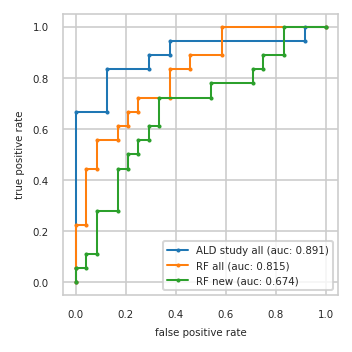

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [30]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.667  0.000 0.222  0.042 0.056
3          0.125 0.667  0.042 0.222  0.042 0.111
4          0.125 0.833  0.042 0.444  0.083 0.111
5          0.292 0.833  0.083 0.444  0.083 0.278
6          0.292 0.889  0.083 0.556  0.167 0.278
7          0.375 0.889  0.167 0.556  0.167 0.444
8          0.375 0.944  0.167 0.611  0.208 0.444
9          0.917 0.944  0.208 0.611  0.208 0.500
10         0.917 1.000  0.208 0.667  0.250 0.500
11         1.000 1.000  0.250 0.667  0.250 0.556
12           NaN   NaN  0.250 0.722  0.292 0.556
13           NaN   NaN  0.375 0.722  0.292 0.611
14           NaN   NaN  0.375 0.833  0.333 0.611
15           NaN   NaN  0.458 0.833  0.333 0.722
16           NaN   NaN  0.458 0.889  0.542 0.722
17           NaN   NaN  0.583 0.889  0.542 0.778
18           NaN   NaN  0.583 1.000  0.708 0.778
19           NaN   NaN  1.000 1.000  0.708 0.833
20           NaN   NaN    NaN   NaN  0.750 0.833
21           NaN   NaN    NaN   NaN  0.750 0.889
22           NaN   NaN    NaN   NaN  0.833 0.889
23           NaN   NaN    NaN   NaN  0.833 1.000
24           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected

In [31]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P31321
1,Q9NX62,P60709;P63261,O60565
2,Q641Q3;Q641Q3-2,F8WE04;P04792,E9PK25;G3V1A4;P23528
3,P61981,C9JIZ6;P07602;P07602-2;P07602-3,J3KSJ8;Q9UD71;Q9UD71-2
4,P14174,P10636-2;P10636-6,Q14894
5,P04075,P04075,P51688
6,C9JF17;P05090,P14174,Q96GD0
7,Q9Y2T3;Q9Y2T3-3,P61981,A0A075B7B8
8,Q6EMK4,P00492,Q504Y2


### Precision-Recall plot

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


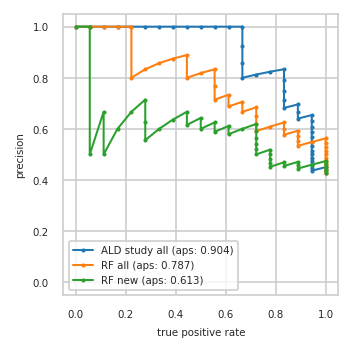

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [33]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.444 0.889
7          0.486 0.944     0.514 1.000     0.457 0.889
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.548 0.944     0.452 0.778
12         0.567 0.944     0.533 0.889     0.467 0.778
13         0.586 0.944     0.552 0.889     0.483 0.778
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.609 0.778     0.565 0.722
20         0.682 0.833     0.591 0.722     0.591 0.722
21         0.714 0.833     0.619 0.722     0.619 0.722
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.684 0.722     0.579 0.611
24         0.833 0.833     0.667 0.667     0.611 0.611
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.812 0.722     0.688 0.611     0.625 0.556
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.923 0.667     0.769 0.556     0.615 0.444
30         1.000 0.667     0.833 0.556     0.667 0.444
31         1.000 0.611     0.818 0.500     0.636 0.389
32         1.000 0.556     0.800 0.444     0.600 0.333
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


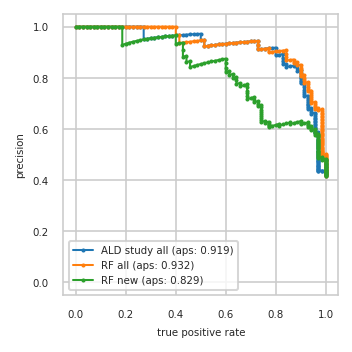

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


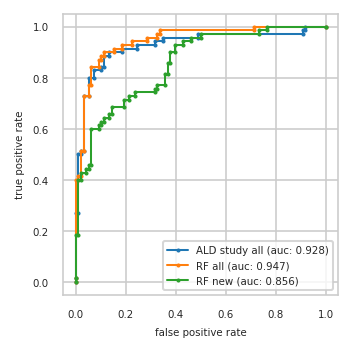

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Options:
- F1 results for test data for best cutoff on training data?
  (select best cutoff of training data, evaluate on test data)
- plot X_train PCA/UMAP, map X_test

Output files:

In [36]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}